# Question 2

In this question we will:
- Implement the vector median filter for colour images.
- Apply the vector median filter to a small dataset and establish a baseline performance meteric.
- Try to design a denoising pipeline that outperforms using only the vector median filter.   

# Step 1: Implement the vector median filter for colour images.

## Instructions

- Write a function that implements the vector median filter.  Details on the vector median filter can be found in Topic 4 of the lecture notes and implementation suggestions can be found in Section 2 of the asignment PDF.  
- The parameters to your function should be the input image `I`, and the `radius` of the square neighbourhood, e.g. radius 1 = 3x3 filter, radius 2 = 5x5 filter, etc.
- Your function should accept images of dtype `uint8` or `float64` (other types may be rejected if you wish).    It is easiest if you work with the image as data type `float64`.   If the input image is of type `uint8`, it is suggested that you convert it to dtype `float64`, construct the output image also as type `float64` and then convert it back to `uint8` before returning it.  In any case, the output image returned should be the same dtype as the input image.

In [78]:
import skimage.util as skutil
import numpy as np

def vector_median(I, radius):
    
    # Fill in the function here.
    orig_dtype = I.dtype
    if orig_dtype == np.uint8:
        I = skutil.img_as_float(I)
    elif orig_dtype != np.float64:
        raise TypeError("Input image must be dtype uint8 or float64")

    rows, cols, ch = I.shape
    
    out = np.zeros_like(I)
    pad = np.pad(I, ((radius,radius), (radius,radius), (0,0)), mode="edge")
    
    size = 2*radius + 1
    n = size * size

    for r in range(rows):
        for c in range(cols):
            Iwindow = pad[r:r+size, c:c+size, :]
            colours = np.reshape(Iwindow, (n, 3)) 

            Y = np.tile(colours[:, :, None], (1, 1, n))        # (n, 3, n)
            X = np.transpose(np.tile(colours[None, :, :], (n, 1, 1)), (0, 2, 1))

            D = np.sum(np.abs(X - Y), axis=(0,1))
            k = np.argmin(D)
            out[r, c] = colours[k]

    if orig_dtype == np.uint8:
        out = skutil.img_as_ubyte(out)
        
    return out

# Step 2a: Establish a Baseline

## Instructions

- Determine the PSNR and SSIM of all of the noisy images by comparing them to their noiseless versions -- store these in a list.  
    - Use the same method to read the images files as in question 1, but read them from the `images/noisy` directory and the `images/noiseless` directory as needed.
- Filter each noisy image with a 3x3 vector median filter and compute the PSNR and SSIM of all of the filtered noisy images (by comparing them to the noiseless images) -- store these in a list.   
    - As with question 1, to save time we recommend you develop and debug your programs using only the first three to five images in file_list, and run it on the complete list when you're done. 
- The noiseless images are provided so you can compute PSNR and SSIM.  See functions `skmetrics.peak_signal_noise_ratio()` and `skmetrics.structural_similarity()`.  You'll need the `channel_axis=2` argument for `structural_similarity()`.  This indicates to the function that the it is the 3rd dimension of the 3D arrays that index the R, G and B channels.

_Hint: This step requires doing a few seemingly different things, but it's actually easier to do them all at once in the same loop._



In [79]:
# Some modules you might need.

import skimage.io as io
import os as os
import skimage.filters as skfilt
import skimage.metrics as skmetrics
import skimage.util as skutil
import numpy as np
import pandas as pd

%matplotlib inline

# Use pandas to read the image filenames and then create a list of the filenames called file_list, just like you did in question 1.
image_files = pd.read_csv("images.csv", header=None)
file_list = image_files[0].tolist()

psnr_noisy = []
ssim_noisy = []
psnr_vmf = []
ssim_vmf = []

for filename in file_list:   # you can restrict this to, for example,  file_list[0:3], for testing

    # Process the noisy image file here.  The images have the same filenames name in the 
    # noisy, noisy-test, and noiseless folders.  You'll have to construct the paths to these
    # images yourself.  This is easy to do using using os.path.join().

    # noisy_path = os.path.join("/u1/cmpt487-819/data/asn1/images/noisy", filename)
    # noisless_path = os.path.join("/u1/cmpt487-819/data/asn1/images/noiseless", filename)
    noisy_path = os.path.join("images/noisy", filename)
    noisless_path = os.path.join("images/noiseless", filename)

    
    noisy = skutil.img_as_float(io.imread(noisy_path))
    noiseless = skutil.img_as_float(io.imread(noisless_path))

    psnr_n = skmetrics.peak_signal_noise_ratio(noiseless, noisy)
    ssim_n = skmetrics.structural_similarity(noiseless, noisy, channel_axis=2, data_range=1.0)

    psnr_noisy.append(psnr_n)
    ssim_noisy.append(ssim_n)

    filtered = vector_median(noisy, radius=1)

    psnr_f = skmetrics.peak_signal_noise_ratio(noiseless, filtered)
    ssim_f = skmetrics.structural_similarity(noiseless, filtered, channel_axis=2, data_range=1.0)

    psnr_vmf.append(psnr_f)
    ssim_vmf.append(ssim_f)

psnr_noisy = np.array(psnr_noisy)
ssim_noisy = np.array(ssim_noisy)
psnr_vmf = np.array(psnr_vmf)
ssim_vmf = np.array(ssim_vmf)

print("Noisy PSNR:", psnr_noisy)
print("Noisy SSIM:", ssim_noisy)
print("VMF PSNR:", psnr_vmf)
print("VMF SSIM:", ssim_vmf)

Noisy PSNR: [19.33650851 20.93531454 20.10529668 19.65041039 19.46408747 21.88763674
 19.19690205 19.8176869  18.0385866  20.16419639 17.99839122 22.91099862
 21.30616405 18.43039364 22.09779972 22.66891889 22.7584212  18.94731035
 21.58674413 20.2296985  19.03251407 17.87844826 18.08616385 21.52415104
 21.6357086  18.88041061 19.31507663 20.31301781 20.19723386 20.69868468
 21.67729015 18.68072571 19.55536747 20.10442378 19.86487798 19.22622283
 18.58169288 20.3333437  20.72353012 22.21339334 23.47175784 18.32386326
 18.83533628 20.14849402 18.3396135  20.44138365 20.31746888 18.73078735
 21.10550834 19.47615699 22.93721815 22.66548981 19.76935009 18.54407775
 19.85407175 20.16365806 23.71213243 22.56287915 18.62297166 19.14830599
 19.76106241 21.36227453 19.86638943 18.75177178 20.58351745 20.78666522
 20.96886708 22.21991519 19.21021077 20.00592742 20.00159257 20.89866041
 19.81559713 19.09362344 20.43924222 20.95507042 19.65667817 21.37806306
 18.87061634 22.39309008 18.30650082 18

# Step 2b: Compute average baseline metrics.

## Instructions

Compute the average PSNR and SSIM for the unfiltered noisy images (take the PSNR and SSIM measures for each image and average them).  Do the same for the median-filtered noisy images.  Plot a bar graph showing the two mean PSNR values and another showing the two mean SSIM values before and after filtering (see assignment description for sample output).

Noisy PSNR: 20.272167535817452
Noisy SSIM: 0.4736273430389255
VMF PSNR: 26.005957987521143
VMF SSIM: 0.647826187129425


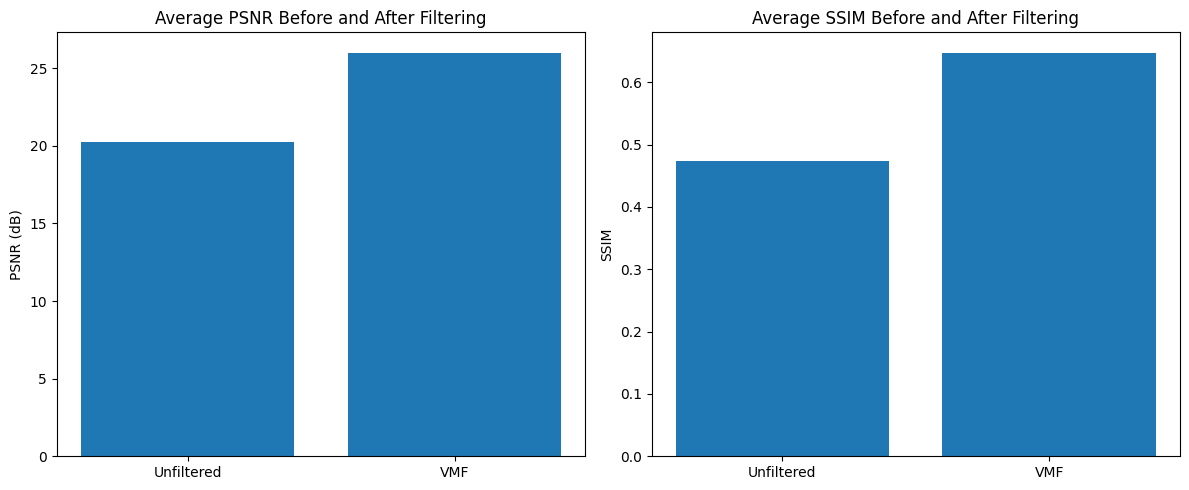

In [80]:
# some modules you might need.

import matplotlib.pyplot as plt
import numpy as np


avg_psnr_unfil = np.mean(psnr_noisy)
avg_ssim_unfil = np.mean(ssim_noisy)

avg_psnr_vmf = np.mean(psnr_vmf)
avg_ssim_vmf = np.mean(ssim_vmf)

print("Noisy PSNR:", avg_psnr_unfil)
print("Noisy SSIM:", avg_ssim_unfil)
print("VMF PSNR:", avg_psnr_vmf)
print("VMF SSIM:", avg_ssim_vmf)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

psnr_min = min(avg_psnr_unfil.min(), avg_psnr_vmf.min())
psnr_max = max(avg_psnr_unfil.max(), avg_psnr_vmf.max())
ssim_min = min(avg_ssim_unfil.min(), avg_ssim_vmf.min())
ssim_max = max(avg_ssim_unfil.max(), avg_ssim_vmf.max())

psnr_margin = 0.05 * (psnr_max - psnr_min)
ssim_margin = 0.05 * (ssim_max - ssim_min)

axes[0].bar(["Unfiltered", "VMF"], [avg_psnr_unfil, avg_psnr_vmf])
axes[0].set_title("Average PSNR Before and After Filtering")
axes[0].set_ylabel("PSNR (dB)")

# SSIM bar chart
axes[1].bar(["Unfiltered", "VMF"], [avg_ssim_unfil, avg_ssim_vmf])
axes[1].set_title("Average SSIM Before and After Filtering")
axes[1].set_ylabel("SSIM")

plt.tight_layout()
plt.show()

# Step 3:  See if you can do better!

Find a better way to denoise the images.  Compute the mean PSNR and SSIM for your denoising method.   Replot the graphs in the previous step with the new results added.

_You can use any functions in the python libraries to help you (numpy, scipy, skimage, etc.) but you cannot bring in code from external sources._


Noisy PSNR: [19.33650851 20.93531454 20.10529668 19.65041039 19.46408747 21.88763674
 19.19690205 19.8176869  18.0385866  20.16419639 17.99839122 22.91099862
 21.30616405 18.43039364 22.09779972 22.66891889 22.7584212  18.94731035
 21.58674413 20.2296985  19.03251407 17.87844826 18.08616385 21.52415104
 21.6357086  18.88041061 19.31507663 20.31301781 20.19723386 20.69868468
 21.67729015 18.68072571 19.55536747 20.10442378 19.86487798 19.22622283
 18.58169288 20.3333437  20.72353012 22.21339334 23.47175784 18.32386326
 18.83533628 20.14849402 18.3396135  20.44138365 20.31746888 18.73078735
 21.10550834 19.47615699 22.93721815 22.66548981 19.76935009 18.54407775
 19.85407175 20.16365806 23.71213243 22.56287915 18.62297166 19.14830599
 19.76106241 21.36227453 19.86638943 18.75177178 20.58351745 20.78666522
 20.96886708 22.21991519 19.21021077 20.00592742 20.00159257 20.89866041
 19.81559713 19.09362344 20.43924222 20.95507042 19.65667817 21.37806306
 18.87061634 22.39309008 18.30650082 18

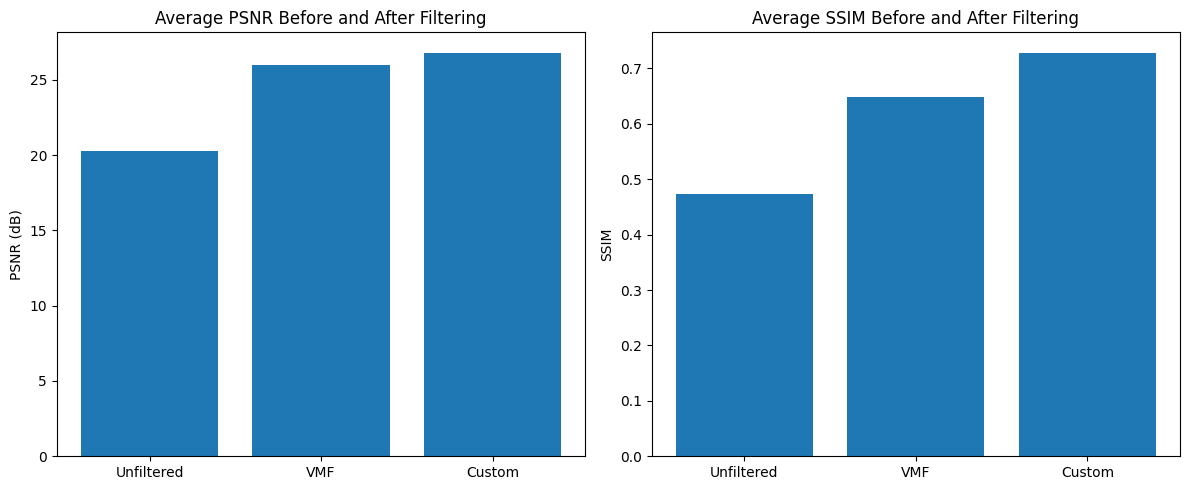

In [81]:
# Write your de-noising method here.
psnr_custom = []
ssim_custom = []

for filename in file_list:   # you can restrict this to, for example,  file_list[0:3], for testing

    # Process the noisy image file here.  The images have the same filenames name in the 
    # noisy, noisy-test, and noiseless folders.  You'll have to construct the paths to these
    # images yourself.  This is easy to do using using os.path.join().

    # noisy_path = os.path.join("/u1/cmpt487-819/data/asn1/images/noisy", filename)
    # noisless_path = os.path.join("/u1/cmpt487-819/data/asn1/images/noiseless", filename)
    noisy_path = os.path.join("images/noisy", filename)
    noisless_path = os.path.join("images/noiseless", filename)
    noisy = skutil.img_as_float(io.imread(noisy_path))
    noiseless = skutil.img_as_float(io.imread(noisless_path))

    img = vector_median(noisy, radius=1)


    custom = skfilt.gaussian(img, sigma=0.7, channel_axis=2)


    psnr_c = skmetrics.peak_signal_noise_ratio(noiseless, custom)
    ssim_c = skmetrics.structural_similarity(noiseless, custom, channel_axis=2, data_range=1.0)

    psnr_custom.append(psnr_c)
    ssim_custom.append(ssim_c)


psnr_custom = np.array(psnr_custom)
ssim_custom = np.array(ssim_custom)

print("Noisy PSNR:", psnr_noisy)
print("Noisy SSIM:", ssim_noisy)
print("VMF PSNR:", psnr_vmf)
print("VMF SSIM:", ssim_vmf)
print("Custom PSNR:", psnr_custom)
print("Custom SSIM:", ssim_custom)

avg_psnr_custom = np.mean(psnr_custom)
avg_ssim_custom = np.mean(ssim_custom)

print("Noisy PSNR:", avg_psnr_unfil)
print("Noisy SSIM:", avg_ssim_unfil)
print("VMF PSNR:", avg_psnr_vmf)
print("VMF SSIM:", avg_ssim_vmf)
print("Custom PSNR:", avg_psnr_custom)
print("Custom SSIM:", avg_ssim_custom)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

psnr_min = min(avg_psnr_unfil.min(), avg_psnr_vmf.min(), avg_psnr_custom.min())
psnr_max = max(avg_psnr_unfil.max(), avg_psnr_vmf.max(), avg_psnr_custom.max())
ssim_min = min(avg_ssim_unfil.min(), avg_ssim_vmf.min(), avg_ssim_custom.min())
ssim_max = max(avg_ssim_unfil.max(), avg_ssim_vmf.max(), avg_ssim_custom.max())

psnr_margin = 0.05 * (psnr_max - psnr_min)
ssim_margin = 0.05 * (ssim_max - ssim_min)

axes[0].bar(["Unfiltered", "VMF", "Custom"], [avg_psnr_unfil, avg_psnr_vmf, avg_psnr_custom])
axes[0].set_title("Average PSNR Before and After Filtering")
axes[0].set_ylabel("PSNR (dB)")

# SSIM bar chart
axes[1].bar(["Unfiltered", "VMF", "Custom"], [avg_ssim_unfil, avg_ssim_vmf, avg_ssim_custom])
axes[1].set_title("Average SSIM Before and After Filtering")
axes[1].set_ylabel("SSIM")

plt.tight_layout()
plt.show()